<a href="https://colab.research.google.com/github/Kgs-Mathaba/TensorFlow_Development_ZTM/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sat Oct 23 20:25:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#import helper script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-23 20:25:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-23 20:25:39 (49.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [5]:
# get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-10-23 20:25:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 209.85.200.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  92.5MB/s    in 1.7s    

2021-10-23 20:25:43 (92.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# check out how mant images and subdirectories in the dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
# Create and test directories path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size =  BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size =  BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
# check out class names of the dataser
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
train_data_10_percent.snapshot

<bound method DatasetV2.snapshot of <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>>

In [12]:
# see an example of the batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.04132652e+01 1.44132652e+01 2.74132652e+01]
   [3.10000000e+01 1.50000000e+01 2.80000000e+01]
   [3.10000000e+01 1.50000000e+01 2.80000000e+01]
   ...
   [6.00000000e+01 4.40000000e+01 4.40000000e+01]
   [6.00000000e+01 4.40000000e+01 4.40000000e+01]
   [6.00000000e+01 4.40000000e+01 4.40000000e+01]]

  [[3.00714283e+01 1.40714283e+01 2.70714283e+01]
   [3.00714283e+01 1.40714283e+01 2.70714283e+01]
   [3.00714283e+01 1.40714283e+01 2.70714283e+01]
   ...
   [6.00000000e+01 4.40000000e+01 4.50000000e+01]
   [6.00000000e+01 4.40000000e+01 4.50000000e+01]
   [6.00000000e+01 4.40000000e+01 4.50000000e+01]]

  [[2.61428566e+01 1.21428566e+01 2.71428566e+01]
   [2.55867348e+01 1.15867348e+01 2.65867348e+01]
   [2.45714283e+01 1.05714283e+01 2.55714283e+01]
   ...
   [6.00000000e+01 4.40000000e+01 4.50000000e+01]
   [6.00000000e+01 4.40000000e+01 4.50000000e+01]
   [6.00000000e+01 4.40000000e+01 4.50000000e+01]]

  ...

  [[3.77857361e+01 1.77857361e+01 2.95714722e+01]
   [3

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D{x.shape}")
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D(None, 1280)


In [14]:
model_0.compile(loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [15]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name = "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211023-202556
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 45s 388ms/step - loss: 1.8933 - accuracy: 0.3933 - val_loss: 1.3544 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 7s 263ms/step - loss: 1.1434 - accuracy: 0.7360 - val_loss: 0.9036 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 7s 263ms/step - loss: 0.8379 - accuracy: 0.8160 - val_loss: 0.7693 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - 7s 263ms/step - loss: 0.6923 - accuracy: 0.8400 - val_loss: 0.6523 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 7s 263ms/step - loss: 0.5887 - accuracy: 0.8613 - val_loss: 0.6172 - val_accuracy: 0.8372


In [16]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 0.6093 - accuracy: 0.8404


[0.6093432307243347, 0.840399980545044]

In [17]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [18]:
#summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [19]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


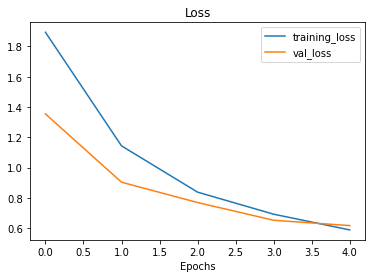

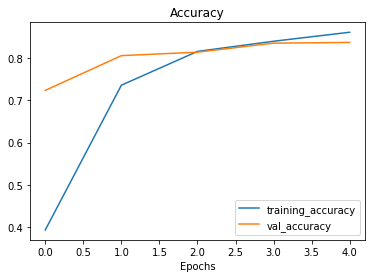

In [20]:
plot_loss_curves(history_10_percent)

In [21]:
## Getting a feature vector
# Demonstrate the Global Average pooling 2d layer
# Define input shape
input_shape = (1, 4, 4, 3)

#Create arandom tensor
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor} \n')

#pass random tensor through a global average pooling 2D layer
global_ave_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'global averaged pooled random tensor:\n {global_ave_tensor}')
print(f'Shape of  averaged pooled random tensor:\n {global_ave_tensor.shape}')

Random input tensor:
 [[[[ 1.3454521   0.66899705  1.0222135 ]
   [-0.93638086  0.20092984  0.70875716]
   [ 1.0904967   0.29340062 -1.8548241 ]
   [-1.882535    0.4913841   1.9205337 ]]

  [[ 0.9802182   1.2685226   1.3953103 ]
   [-0.37127987 -0.44316995 -1.2844058 ]
   [-1.2075714   0.01136521  0.3860061 ]
   [ 0.47664487 -0.09479862  0.95080066]]

  [[-0.04820161  1.7482814  -0.9260487 ]
   [-1.2334064  -1.5226216   0.1101405 ]
   [-0.75412476  0.05605476 -0.8395848 ]
   [ 0.7032986  -0.33974385 -0.3093966 ]]

  [[ 0.9074279   0.7642348   1.3308146 ]
   [ 0.3085954  -0.693643   -0.10574519]
   [ 1.0112185   2.0643148  -1.0186846 ]
   [-2.5336235  -0.6790701   0.7096442 ]]]] 

global averaged pooled random tensor:
 [[-0.1339857   0.23715234  0.13722065]]
Shape of  averaged pooled random tensor:
 (1, 3)


In [22]:
# replicate GlobalAveragePool2D
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.1339857 ,  0.23715234,  0.13722065]], dtype=float32)>

##Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

 Why don't we answer that question while running the following modelling experiments:

1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.
While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the EfficientNetB0 model within the tf.keras.applications module.

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers.experimental.preprocessing module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [23]:
# Donwload andunzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2021-10-23 20:27:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   103MB/s    in 1.2s    

2021-10-23 20:27:35 (103 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [24]:
# Create training and test directories
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [25]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [26]:
# Setup data loaders
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMAGE_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMAGE_SIZE,
                                                                           batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
# Add data augmentation layer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horizontal flipping. rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      #preprocessing.Rescale(1./255) # keep for model like RasNet50V2
], name = "data_augmentation")

#Visualize data augmentation

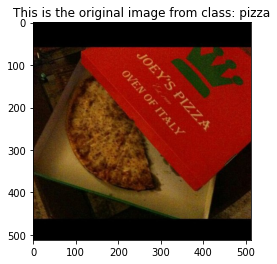

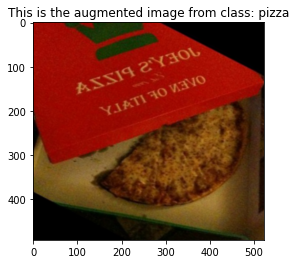

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/"+ random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'This is the original image from class: {target_class}');

# Visualize augmnented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f'This is the augmented image from class: {target_class}');
plt.imshow(tf.squeeze(augmented_img)/255.)


## Model 1: Feature extraction learning on 1% percent of the data with augmentation


In [29]:
# setup the input shape and base, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape,
                      name = "input_layer")

# Add data augmentation as layer
x = data_augmentation(inputs)

# Give base models after inputs are augmented
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer as output
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                #Track model training log
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211023-202741
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 15s 4s/step - loss: 2.3936 - accuracy: 0.0857 - val_loss: 2.2071 - val_accuracy: 0.1859
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1723 - accuracy: 0.2429 - val_loss: 2.0794 - val_accuracy: 0.2714
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9552 - accuracy: 0.4429 - val_loss: 1.9540 - val_accuracy: 0.3799
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8137 - accuracy: 0.5429 - val_loss: 1.8617 - val_accuracy: 0.4523
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6149 - accuracy: 0.6571 - val_loss: 1.7684 - val_accuracy: 0.5164


In [30]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [31]:
# Evaluate on the full test dataset
result_1_percent_dat_aug = model_1.evaluate(test_data)
result_1_percent_dat_aug

79/79 [==============================] - 11s 130ms/step - loss: 1.7725 - accuracy: 0.4968


[1.77254319190979, 0.4968000054359436]

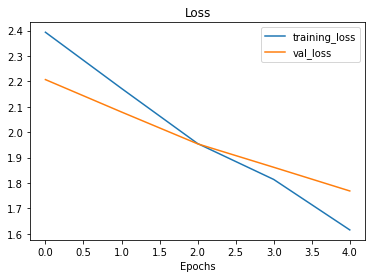

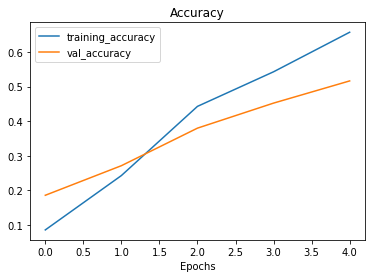

In [32]:
plot_loss_curves(history_1_percent)

In [33]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [34]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:

# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [37]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [38]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211023-202834
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 27s 806ms/step - loss: 1.9717 - accuracy: 0.3573 - val_loss: 1.4459 - val_accuracy: 0.6595

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 15s 582ms/step - loss: 1.3428 - accuracy: 0.6827 - val_loss: 1.0396 - val_accuracy: 0.7484

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 14s 566ms/step - loss: 1.0813 - accuracy: 0.7227 - val_loss: 0.8239 - val_accuracy: 0.8043

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 16s 669ms/step - loss: 0.9217 - accuracy: 0.7640 - val_loss: 0.7371 - val_accuracy: 0.8174

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 16s 649ms/step - loss: 0.8090 - accuracy: 0.7907 - val_

In [39]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6093 - accuracy: 0.8404


[0.6093432903289795, 0.840399980545044]

In [40]:
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 0.7049 - accuracy: 0.8160


[0.704919159412384, 0.8159999847412109]

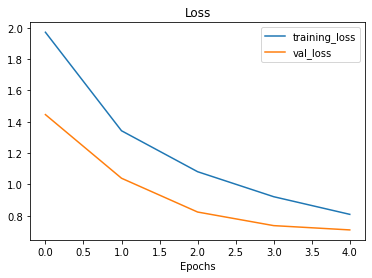

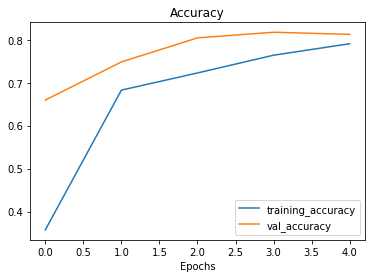

In [41]:
plot_loss_curves(history_10_percent_data_aug)

# Loading in checkpoint weights returns model to a specific checkpoint

In [42]:
# Load in saved model and evaluate
model_2.load_weights(checkpoint_path)

In [43]:
# Evaluate model_2 with the loaded weight
loaded_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.7049 - accuracy: 0.8160


In [44]:
loaded_model_results

[0.7049190998077393, 0.8159999847412109]

In [45]:
result_10_percent_data_aug

[0.704919159412384, 0.8159999847412109]

# Model  3: Fine-tuning an existing model on 10% of the data

In [46]:
# Layer in the loaded model
model_2.layers

In [47]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f990f7c68d0> True
<keras.engine.sequential.Sequential object at 0x7f99e391c6d0> True
<keras.engine.functional.Functional object at 0x7f990f2a3390> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f990f512f90> True
<keras.layers.core.Dense object at 0x7f990f2fbf90> True


In [48]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [49]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [50]:
# Start by setting last ten layers of EfficientB0 bsae model to trainable
base_model.trainable = True


# Freeze all alyers except fo the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [51]:
for layer in base_model.layers[:-10]:
  print(layer.name, layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [52]:
for layer in base_model.layers[-10:]:
  print(layer.name, layer.trainable)

block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [53]:
# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # change the learning so as to not change the weight of EfficientB0 too much
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [54]:
# check which layers are tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
print(len(model_2.trainable_variables))

12


In [56]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 4

# Refit the model (same as model_2 except with more tainable layer)
history_10_percent_data_fine_tuned = model_2.fit(train_data_10_percent,
                                       epochs=fine_tune_epochs,
                                       validation_data=test_data,
                                       validation_steps=int(0.25*len(test_data)),
                                       initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previos last epoch
                                       callbacks=[create_tensorboard_callback(dir_name="tranfer_learning",
                                                                              experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: tranfer_learning/10_percent_fine_tune_last_10/20211023-203114
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 782ms/step - loss: 0.7019 - accuracy: 0.8027 - val_loss: 0.5557 - val_accuracy: 0.8240
Epoch 6/9
24/24 [==============================] - 13s 514ms/step - loss: 0.5836 - accuracy: 0.8213 - val_loss: 0.5266 - val_accuracy: 0.8487
Epoch 7/9
24/24 [==============================] - 15s 605ms/step - loss: 0.5030 - accuracy: 0.8520 - val_loss: 0.5184 - val_accuracy: 0.8470
Epoch 8/9
24/24 [==============================] - 13s 542ms/step - loss: 0.4772 - accuracy: 0.8560 - val_loss: 0.4897 - val_accuracy: 0.8503
Epoch 9/9
24/24 [==============================] - 12s 490ms/step - loss: 0.4179 - accuracy: 0.8613 - val_loss: 0.5289 - val_accuracy: 0.8421


In [57]:
#Evaluate the fine-tuned model_2
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.4982 - accuracy: 0.8384


In [58]:
results_fine_tune_10_percent

[0.4982309937477112, 0.8384000062942505]

In [59]:
result_10_percent_data_aug

[0.704919159412384, 0.8159999847412109]

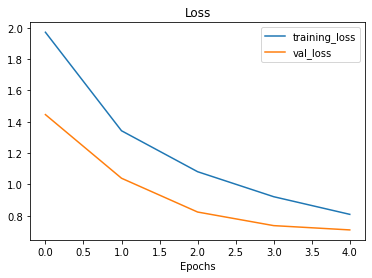

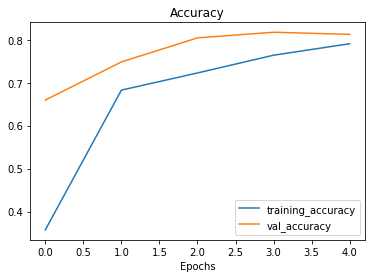

In [60]:
# Check out the loss curves of the fine-tuned model
plot_loss_curves(history_10_percent_data_aug)

In [61]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
10
[0.35733333230018616, 0.6826666593551636, 0.7226666808128357, 0.7639999985694885, 0.7906666398048401, 0.8026666641235352, 0.8213333487510681, 0.8519999980926514, 0.8560000061988831, 0.8613333106040955]


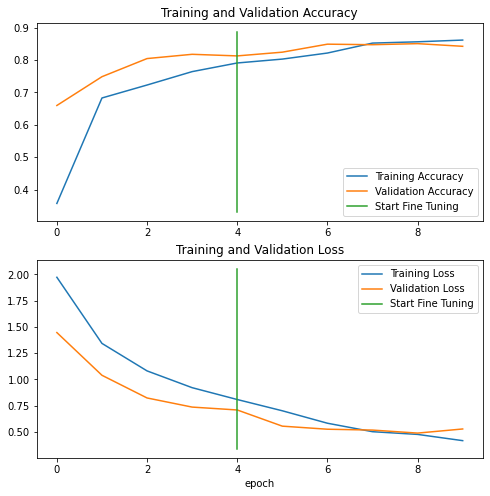

In [62]:
compare_historys(history_10_percent_data_aug,
                 history_10_percent_data_fine_tuned,
                 initial_epochs=5)

## Model 4: Fine tuning the model on all the data


In [63]:
# Download and unzip 10 classes of Food101 with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-10-23 20:44:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   132MB/s    in 3.8s    

2021-10-23 20:44:55 (132 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [64]:
# Setup training ans test directories
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [65]:
# How many images are there
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [68]:
# Setup data input
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size = IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMAGE_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#revert model 2 to its feature extraction weight before fine tuning model 4

In [71]:
# Load weight from checkpoint, to fine tune from the same stage
model_2.load_weights(checkpoint_path)

In [77]:
# evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.7049 - accuracy: 0.8160


[0.7049190998077393, 0.8159999847412109]

In [74]:
results_fine_tune_10_percent

[0.4982309937477112, 0.8384000062942505]

In [75]:
for i,layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [76]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [79]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [81]:
# Continue to fine tune the model to the 100% data
fine_tune_epochs = initial_epochs + 5

history_fine_tune_10_classes_full = model_2.fit(train_data_10_classes_full,
                                                epochs = fine_tune_epochs,
                                                validation_data = test_data,
                                                validation_steps = int(0.25*len(test_data)),
                                                initial_epoch=history_10_percent_data_aug.epoch[-1],
                                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                         experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211023-213707
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 73s 279ms/step - loss: 0.7360 - accuracy: 0.7639 - val_loss: 0.3847 - val_accuracy: 0.8750
Epoch 6/10
235/235 [==============================] - 80s 338ms/step - loss: 0.6003 - accuracy: 0.8048 - val_loss: 0.3525 - val_accuracy: 0.8832
Epoch 7/10
235/235 [==============================] - 72s 304ms/step - loss: 0.5268 - accuracy: 0.8287 - val_loss: 0.3791 - val_accuracy: 0.8717
Epoch 8/10
235/235 [==============================] - 65s 273ms/step - loss: 0.4962 - accuracy: 0.8431 - val_loss: 0.3317 - val_accuracy: 0.8898
Epoch 9/10
235/235 [==============================] - 67s 283ms/step - loss: 0.4522 - accuracy: 0.8561 - val_loss: 0.3245 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 61s 258ms/step - loss: 0.4240 - accuracy: 0.8668 - val_loss: 0.3471 - val_accuracy: 0.8849
